In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [63]:
df = pd.read_csv('train.csv')[['Age','Fare','Survived']]

In [64]:
df.dropna(inplace=True)

In [65]:
df.head()

,Age,Fare,Survived
0,34.5,7.8292,0
1,47.0,7.0000,1
2,62.0,9.6875,0
3,27.0,8.6625,0
4,22.0,12.2875,1


In [66]:
df.shape

(331, 3)

In [67]:
X = df.drop(columns=['Survived'])
y = df['Survived']

In [68]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [69]:
X_train.head()

,Age,Fare
281,0.75,13.7750
96,76.00,78.8500
341,32.00,7.5792
18,27.00,7.9250
26,22.00,61.9792


In [70]:
# Without binarization

clf = DecisionTreeClassifier()

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

accuracy_score(y_test,y_pred)

0.5671641791044776

In [71]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

0.559090909090909

In [72]:
k_age = KBinsDiscretizer(n_bins=4,encode='ordinal',strategy='quantile')
k_fare = KBinsDiscretizer(n_bins=4,encode='ordinal',strategy='quantile')

In [73]:
column_trans = ColumnTransformer([
    ('age',k_age,['Age']),
    ('fare',k_fare,['Fare'])
],remainder='passthrough')

In [74]:
X_train_trf = column_trans.fit_transform(X_train)
X_test_trf = column_trans.transform(X_test)

In [75]:
column_trans.named_transformers_['age'].bin_edges_


array([array([ 0.33, 22.  , 29.  , 40.  , 76.  ])], dtype=object)

In [76]:
column_trans.named_transformers_['fare'].bin_edges_


array([array([  0.     ,   8.62605,  16.     ,  42.425  , 512.3292 ])],
      dtype=object)

In [77]:
output = pd.DataFrame({
    'age':X_train['Age'],
    'age_trf':X_train_trf[:,0],
    'fare':X_train['Fare'],
    'fare_trf':X_train_trf[:,1]
})

In [78]:
output.head()

,age,age_trf,fare,fare_trf
281,0.75,0.0,13.7750,1.0
96,76.00,3.0,78.8500,3.0
341,32.00,2.0,7.5792,0.0
18,27.00,1.0,7.9250,0.0
26,22.00,1.0,61.9792,3.0


In [79]:
output['age_labels'] = pd.cut(x=X_train['Age'],
                                    bins=column_trans.named_transformers_['age'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x=X_train['Fare'],
                                    bins=column_trans.named_transformers_['fare'].bin_edges_[0].tolist())

In [80]:
output.sample(5)


,age,age_trf,fare,fare_trf,age_labels,fare_labels
90,22.0,1.0,13.9000,1.0,"(0.33, 22.0]","(8.626, 16.0]"
309,45.0,3.0,14.1083,1.0,"(40.0, 76.0]","(8.626, 16.0]"
396,24.0,1.0,7.2500,0.0,"(22.0, 29.0]","(0.0, 8.626]"
165,26.0,1.0,22.0250,2.0,"(22.0, 29.0]","(16.0, 42.425]"
37,21.0,0.0,8.6625,1.0,"(0.33, 22.0]","(8.626, 16.0]"


In [81]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)
y_pred2 = clf.predict(X_test_trf)

In [82]:
accuracy_score(y_test,y_pred2)


0.6865671641791045

In [83]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

0.5650623885918004

In [84]:
def discretize(bins,strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)

    trf = ColumnTransformer([
        ('first',kbin_age,[0]),
        ('second',kbin_fare,[1])
    ])

    X_trf = trf.fit_transform(X)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy')))

    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,0],color='red')
    plt.title("After")

    plt.show()

    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,1],color='red')
    plt.title("Fare")

    plt.show()

0.5590017825311943


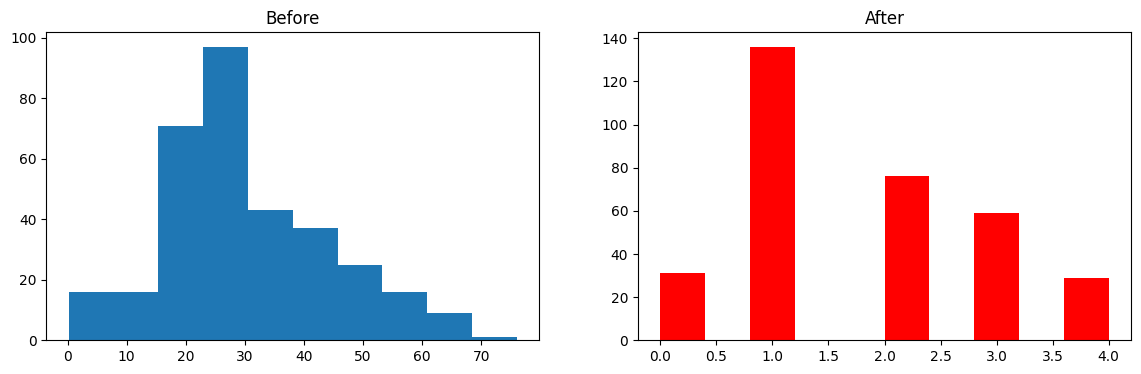

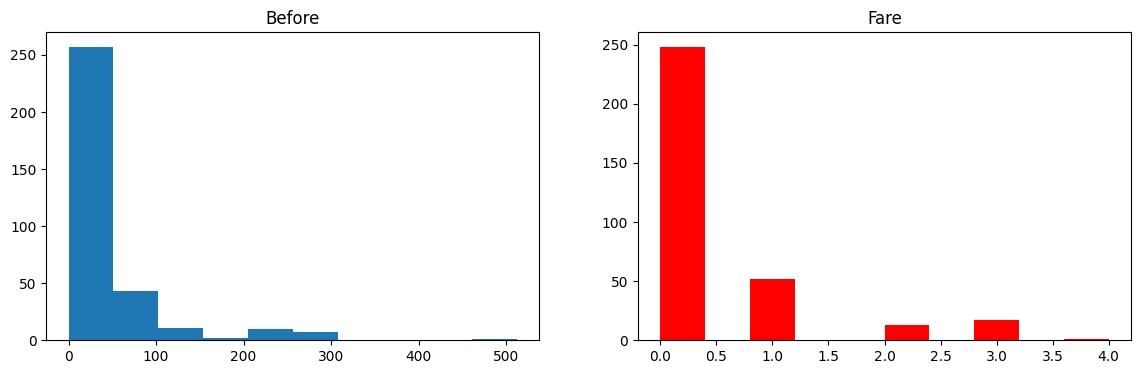

In [85]:
discretize(5,'kmeans')


0.5711229946524063


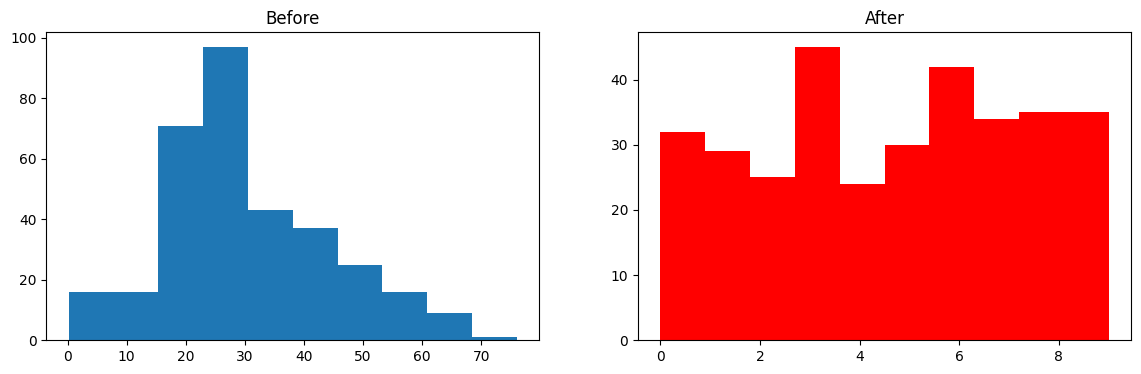

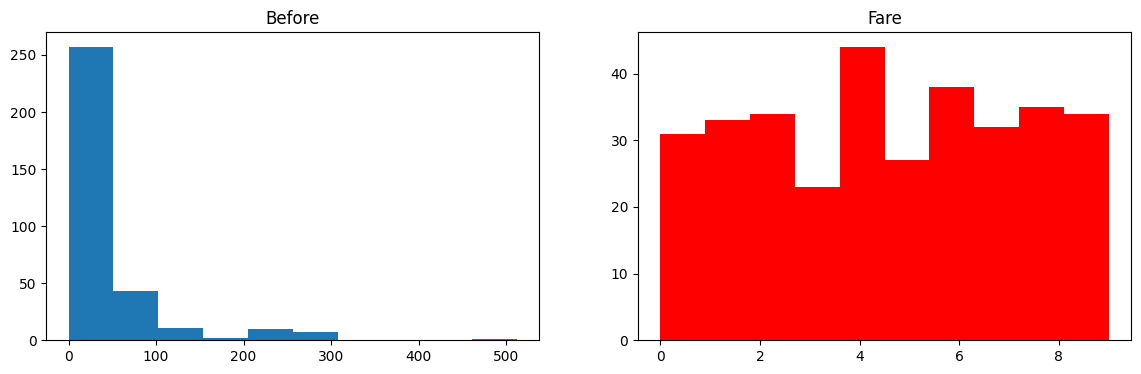

In [86]:
discretize(10,'quantile')


In [87]:
# Applying Binarization

from sklearn.preprocessing import Binarizer

In [88]:
df = pd.read_csv('train.csv')[['Age','Fare','SibSp','Parch','Survived']]


In [89]:
df['family'] = df['SibSp'] + df['Parch']


In [90]:
df.head()

,Age,Fare,SibSp,Parch,Survived,family
0,34.5,7.8292,0,0,0,0
1,47.0,7.0000,1,0,1,1
2,62.0,9.6875,0,0,0,0
3,27.0,8.6625,0,0,0,0
4,22.0,12.2875,1,1,1,2


In [91]:
df.drop(columns=['SibSp','Parch'],inplace=True)


In [92]:
df.dropna(inplace=True)


In [93]:
X = df.drop(columns=['Survived'])
y = df['Survived']

In [94]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [95]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)
y_pred2 = clf.predict(X_test_trf)

accuracy_score(y_test,y_pred2)

0.6865671641791045

In [96]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))


0.6013368983957219

# Applying Binarization


In [97]:

from sklearn.preprocessing import Binarizer
trf = ColumnTransformer([
    ('bin',Binarizer(copy=False),['family'])
],remainder='passthrough')
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)
pd.DataFrame(X_train_trf,columns=['family','Age','Fare'])

,family,Age,Fare
0,1.0,0.75,13.7750
1,1.0,76.00,78.8500
2,0.0,32.00,7.5792
3,1.0,27.00,7.9250
4,1.0,22.00,61.9792
...,...,...,...
259,0.0,20.00,7.2250
260,0.0,27.00,7.8792
261,0.0,43.00,7.8958
262,0.0,16.00,7.6500


In [98]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)
y_pred2 = clf.predict(X_test_trf)

accuracy_score(y_test,y_pred2)

0.5970149253731343

In [99]:
X_trf = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(),X_trf,y,cv=10,scoring='accuracy'))

0.6193404634581106